In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'          # use the generic “serif” family
# (optional) tell matplotlib which concrete serif faces you prefer, in priority order:
mpl.rcParams['font.serif'] = ['Times New Roman', 'STIXGeneral', 'DejaVu Serif']

mpl.rcParams['mathtext.fontset'] = 'cm'



def generate_data(n_inliers=100, n_outliers=20, d=3):
   
    
    
    D = d + 1

    
    A = np.random.randn(D, D)
    A1 = np.random.randn(D, D)
    Q, _ = np.linalg.qr(A)
    Q1, _ = np.linalg.qr(A1)

    
    P_inlier = Q[:, :d]  # shape: (D, d)
    P_orth = Q1[:,1:]
    P_outlier = Q1[:, d]  # shape: (D,)

   
    inliers = np.random.randn(n_inliers, d)
    inliers_embedded = inliers @ P_inlier.T

    
    outliers = np.random.randn(n_outliers, 1)
    outliers_embedded = outliers * P_outlier.reshape(1, -1)

    
    data = np.concatenate([inliers_embedded, outliers_embedded], axis=0)

    
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data_normalized = data / norms

    return data_normalized, P_inlier,P_orth

In [19]:
def FMS_small2(X, dd, L0):
    D, N = X.shape
    max_iter = 400
    L = L0.copy()
    L_intermediate = {}
    iter_count = 1
    
    
    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()
        
        residual = (np.eye(D) - L @ L.T) @ X
        w = np.maximum(1e-10, np.sqrt(np.sum(residual**2, axis=0)))
        
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T
        
        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]
        
        # Compute a convergence metric (e.g. based on subspace angles)
        ang = np.linalg.norm(subspace_angles(L, L_old))
        
        # Store intermediate L for this iteration
        L_intermediate[iter_count] = L.copy()
        
    return L, L_intermediate

def FMS_ex2(X, dd, L0):
    D, N = X.shape
    max_iter = 400
    L = L0.copy()
    L_intermediate = {}
    iter_count = 1
    
    
    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()
        
        residual = (np.eye(D) - L @ L.T) @ X
        w = np.maximum(1e-15, np.sqrt(np.sum(residual**2, axis=0)))
        
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T
        
        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]
        
        # Compute a convergence metric (e.g. based on subspace angles)
        ang = np.linalg.norm(subspace_angles(L, L_old))
        
        # Store intermediate L for this iteration
        L_intermediate[iter_count] = L.copy()
        
    return L, L_intermediate


def FMS_large2(X, dd,L0):
    
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=400

    # Initialize using SVD of the raw data
    #U, _, _ = np.linalg.svd(X, full_matrices=False)
    #L = U[:, :dd]
    L = L0


    # Dictionary to store intermediate L values
    L_intermediate = {}

    # Initialize residual angle
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L.copy()

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L @ L.T) @ X

        # Compute weights with a small regularization
        w = np.maximum(1e-3, np.sqrt(np.sum(residual**2, axis=0)))


        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate

def FMS_dc2(X, dd,gamma,L0):
   
    D, N = X.shape
    iter_count = 1
    tol=1e-12 
    max_iter=400
    # Initialize using SVD of the raw data
    #U, _, _ = np.linalg.svd(X, full_matrices=False)
    #L = U[:, :dd]
    L = L0


    residual = (np.eye(D) - L @ L.T) @ X
    distances = np.sqrt(np.sum(residual**2, axis=0))
    epsilon = np.quantile(distances, gamma)

    L_intermediate = {}
    

    # Initialize residual angle
    ang = 1

    for iter_count in range(1, max_iter + 1):
        L_old = L

        # Residual projection onto the orthogonal complement of L
        residual = (np.eye(D) - L_old @ L_old.T) @ X
        distances = np.sqrt(np.sum(residual**2, axis=0))
        
        # Update smoothing parameter: dynamic update based on the gamma-th quantile.
        q_gamma_val = np.quantile(distances, gamma)
        epsilon = min(epsilon, q_gamma_val)
        
        w = np.maximum(epsilon, distances)
       
        # Reweight the data matrix
        XX = X @ np.diag(1.0 / w) @ X.T

        # Update L via SVD of the reweighted matrix
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute convergence metric using your subspace_angles function
        ang = np.linalg.norm(subspace_angles(L, L_old))

        L_intermediate[iter_count] = L.copy()

        iter_count += 1

    return L, L_intermediate

np.random.seed(42)
num1 = 100
num2 = 30
d = 3
data, P_true,P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
U, _, _ = np.linalg.svd(data.T, full_matrices=False)
L0 = U[:, :d]  


# Run your methods
P_small, L_small = FMS_small2(data.T, d,L0) 
P_ex,L_ex = FMS_ex2(data.T,d,L0)
P_large, L_large = FMS_large2(data.T, d,L0) 
P_dc, L_dc       = FMS_dc2(data.T, d, 0.5,L0)    
P_dc2,L_dc2 = FMS_dc2(data.T,d,0.1,L0)
# Get the keys from each intermediate dictionary
keys_small = set(L_small.keys())
keys_large = set(L_large.keys())
keys_dc    = set(L_dc.keys())

m = 200
errors_small = np.zeros(m)
errors_ex    = np.zeros(m)
errors_large = np.zeros(m)
errors_dc    = np.zeros(m)
errors_dc2   = np.zeros(m)

for i in range(1, m + 1):
    errors_small[i-1] = np.linalg.norm(L_small[i] @ L_small[i].T - P_true @ P_true.T)
    errors_ex[i-1]    = np.linalg.norm(L_ex[i]    @ L_ex[i].T    - P_true @ P_true.T)
    errors_large[i-1] = np.linalg.norm(L_large[i] @ L_large[i].T - P_true @ P_true.T)
    errors_dc[i-1]    = np.linalg.norm(L_dc[i]    @ L_dc[i].T    - P_true @ P_true.T)
    errors_dc2[i-1]   = np.linalg.norm(L_dc2[i]   @ L_dc2[i].T   - P_true @ P_true.T)


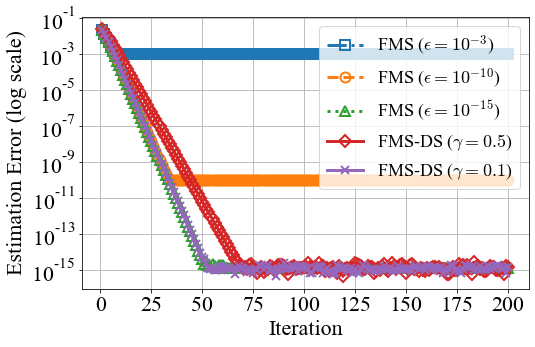

In [20]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, m+1), errors_large, 's-.', linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-3}$)')
plt.plot(range(1, m+1), errors_small, 'o--', linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(range(1, m+1), errors_ex, '^:', linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-15}$)')
plt.plot(range(1, m+1), errors_dc, 'D-', linewidth=3, markersize=8,
         markeredgewidth=2, fillstyle='none', label='FMS-DS ($\\gamma=0.5$)')
plt.plot(range(1, m+1), errors_dc2, 'x-', linewidth=3, markersize=8,
         markeredgewidth=2, fillstyle='none', label='FMS-DS ($\\gamma=0.1$)')

plt.xlabel('Iteration', fontsize=22)
plt.ylabel('Estimation Error (log scale)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.yscale("log")
plt.legend(loc='upper right', fontsize=18, frameon=True)
plt.grid(True)
plt.savefig('exp3_1.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:

num1 = 100
num2 = 25
d = 3
data, P_true,P_orth = generate_data(n_inliers=num1, n_outliers=num2, d=d)
U, _, _ = np.linalg.svd(data.T, full_matrices=False)
L0 = P_orth 


# Run your methods
P_small, L_small = FMS_small2(data.T, d,L0) 
P_ex,L_ex = FMS_ex2(data.T,d,L0)
P_large, L_large = FMS_large2(data.T, d,L0) 
P_dc, L_dc       = FMS_dc2(data.T, d, 0.5,L0)    
P_dc2,L_dc2 = FMS_dc2(data.T,d,0.1,L0)
# Get the keys from each intermediate dictionary
keys_small = set(L_small.keys())
keys_large = set(L_large.keys())
keys_dc    = set(L_dc.keys())

m = 200
errors_small = np.zeros(m)
errors_ex    = np.zeros(m)
errors_large = np.zeros(m)
errors_dc    = np.zeros(m)
errors_dc2   = np.zeros(m)

for i in range(1, m + 1):
    errors_small[i-1] = np.linalg.norm(L_small[i] @ L_small[i].T - P_true @ P_true.T)
    errors_ex[i-1]    = np.linalg.norm(L_ex[i]    @ L_ex[i].T    - P_true @ P_true.T)
    errors_large[i-1] = np.linalg.norm(L_large[i] @ L_large[i].T - P_true @ P_true.T)
    errors_dc[i-1]    = np.linalg.norm(L_dc[i]    @ L_dc[i].T    - P_true @ P_true.T)
    errors_dc2[i-1]   = np.linalg.norm(L_dc2[i]   @ L_dc2[i].T   - P_true @ P_true.T)


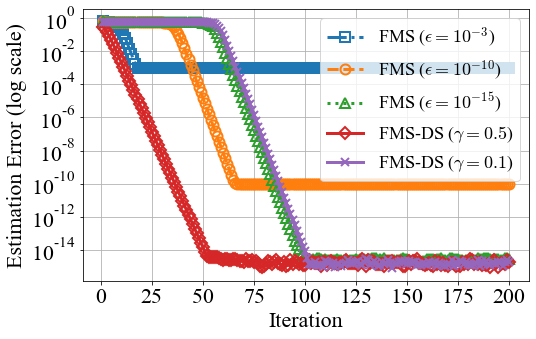

In [22]:
plt.figure(figsize=(8, 5))

plt.plot(range(1, m+1), errors_large, 's-.', linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-3}$)')
plt.plot(range(1, m+1), errors_small, 'o--', linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-10}$)')
plt.plot(range(1, m+1), errors_ex, '^:', linewidth=3, markersize=10,
         markeredgewidth=2, fillstyle='none', label='FMS ($\\epsilon=10^{-15}$)')
plt.plot(range(1, m+1), errors_dc, 'D-', linewidth=3, markersize=8,
         markeredgewidth=2, fillstyle='none', label='FMS-DS ($\\gamma=0.5$)')
plt.plot(range(1, m+1), errors_dc2, 'x-', linewidth=3, markersize=8,
         markeredgewidth=2, fillstyle='none', label='FMS-DS ($\\gamma=0.1$)')

plt.xlabel('Iteration', fontsize=22)
plt.ylabel('Estimation Error (log scale)', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.yscale("log")
plt.legend(loc='upper right', fontsize=18, frameon=True)
plt.grid(True)
plt.savefig('exp3_2.png', dpi=300, bbox_inches='tight')
plt.show()
